#  Lending_Club - Interest_Rate_Prediction

# Description
1. For the Loan Lending club, it's extremely important to know how's the loan repayment capacity for each loan applicant, and how much interest rate should be assigned to each loan application appropriately. 
    - Firstly, knowing the loan repayment capacity for each loan applicant could help it decide whether to "accept" or "deny" a loan application. 
    - Second, evaluating interest rate precisely could bring an additional incentive for those who are willing to "lend" money and also attain a balance between demand (borrowers) and supply (lenders).
2. As a result, some suitable metrics must be determined by looking at the dataset.
    - **Metrics**
        - loan status: To evaluate the loan repayment capacity for each loan applicant.
        - grade: A good categorical index to know the loan repayment capacity.
        - interest rate: A numerical feature playing a role of balancing demand and supply. 
3. In this jupyter notebook, we bulid models to predict **'Interest_Rate'** with matric **'int_rate'**.

## Main Task

1. Prepare the dataset 
2. Categorical Feature Transformation
    - 2.1 One-hot encoding
    - 2.2 Dummy features
3. Data preprocessing
    - 3.1 Split data into train and test sets
    - 3.2 Standarize data
4. Modeling
    - 4.1 Linear Regression
        - 4.1.1 Randomized Grid Search - Linear Regression
        - 4.1.2 Model performance evaluation: MSE and R-squared
    - 4.2 Bagged Decision Tree Regression
        - 4.2.1 RandomizedSearchCV - Bagged Decision Tree Regression
        - 4.2.2 Model performance evaluation: MSE and R-squared
    - 4.3 Random Forest Regression
        - 4.3.1 Randomized Grid Search - Random Forest Regression
        - 4.3.2 Model performance evaluation: MSE and R-squared
    - 4.4 Gradient Boosting Regression
        - 4.4.1 Randomized Grid Search - Gradient Boosting Regression
        - 4.4.2 Model performance evaluation: MSE and R-squared
5. Summary
    - 5.1 Feature Conclusion
    - 5.2 Model Comparison
    - 5.3 Next Step

In [55]:
# Data structure packages
import pandas as pd
import numpy as np

# Machine Learning packages
import time
import math
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix

from PIL import Image

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## 1. Prepare the dataset

In [56]:
# load data
loan = pd.read_csv("../data/final_LC_loan.csv")

In [3]:
# Should exclude other response features before modeling
no_other_response_loan = loan.drop(['loan_status', 'loan_status_binary', 'sub_grade', 'grade', 'int_rate'], axis = 1)

#### exclude Loan payment related features which are unavailable when we try to predict Interest Rate

In [4]:
# exclude Loan payment related features which are unavailable when we try to predict Interest Rate
pyment_related = ['installment', 'funded_amnt', 'funded_amnt_inv', 'last_pymnt_amnt', 'level_diff_last_issue_d', 
                  'level_diff_next_issue_d', 'pymnt_plan', 'total_pymnt' ,'total_pymnt_inv', 'total_rec_int', 
                'total_rec_prncp', 'out_prncp', 'out_prncp_inv']

In [5]:
# exclude target label related features
no_other_response_loan = no_other_response_loan.drop(pyment_related, axis = 1)
y = loan.int_rate.values

## 2. Categorical Feature Transformation

### 2.1 One-hot encoding 

In [6]:
# Collect column names, check missing value 
one_hot_column = []
dummy_column = []

for each in no_other_response_loan:
    if no_other_response_loan[each].dtype == 'object':
        # Check NA values again
        print(each, no_other_response_loan[each].isnull().sum())
        if len(no_other_response_loan[each].unique()) <= 2:
            one_hot_column.append(each)
        elif len(no_other_response_loan[each].unique()) > 2:
            dummy_column.append(each)

term 0
emp_length 0
home_ownership 0
verification_status 0
purpose 0
title 0
initial_list_status 0
application_type 0
hardship_flag 0
hardship_type 0
hardship_reason 0
hardship_status 0
hardship_loan_status 0
disbursement_method 0
debt_settlement_flag 0
settlement_status 0
days_between_issue_payment_plan_start_date 0
days_between_issue_hardship_start_date 0
days_between_issue_hardship_end_date 0
level_between_issue_settlement_date 0
level_between_max_issue_sec_earliest_cr_line 0
level_since_last_credit_pull 0
T_unique_title 0
level_since_issue 0
level_between_max_issue_earliest_cr_line 0
group_state 0


In [7]:
# One-hot encoding for categorical variables containing two levels
le = LabelEncoder()
le_count = 0

for col in one_hot_column:
    print(col)
    le.fit(no_other_response_loan[col])
    no_other_response_loan[col] = le.transform(no_other_response_loan[col])
            
    # Keep track of how many columns were label encoded
    le_count += 1
            
print('%d columns were label encoded.' % le_count)

term
initial_list_status
application_type
hardship_flag
hardship_type
hardship_status
disbursement_method
debt_settlement_flag
settlement_status
9 columns were label encoded.


### 2.2 Dummy features

In [8]:
# Create dummy features
sum_len = 0
for col in dummy_column:
    sum_len += len(no_other_response_loan[col].unique())
    print(col, len(no_other_response_loan[col].unique()))
    
print('In total:', sum_len - len(dummy_column), 'will be additionally added.')

emp_length 12
home_ownership 4
verification_status 3
purpose 13
title 12
hardship_reason 3
hardship_loan_status 3
days_between_issue_payment_plan_start_date 3
days_between_issue_hardship_start_date 4
days_between_issue_hardship_end_date 3
level_between_issue_settlement_date 5
level_between_max_issue_sec_earliest_cr_line 11
level_since_last_credit_pull 10
T_unique_title 21
level_since_issue 3
level_between_max_issue_earliest_cr_line 10
group_state 5
In total: 108 will be additionally added.


## 3. Data preprocessing

### 3.1 Split data into train and test sets

In [9]:
# Seperate features into x (independent features) and y (dependent feature)
print(no_other_response_loan.shape)
print(y.shape)

(107864, 81)
(107864,)


In [10]:
# 81 + 108 = 189, correct dummy feature transformation!
x = pd.get_dummies(no_other_response_loan, columns = dummy_column)
print(x.shape)

(107864, 189)


In [11]:
# Split data into train and test (80% & 20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, random_state = 1)

### 3.2 Standarize data

In [12]:
# Before modeling, standardize each feature
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

In [13]:
print(x_train_std.shape)
print(x_test_std.shape)
print(len(y_train))
print(len(y_test))

(86291, 189)
(21573, 189)
86291
21573


## 4. Modeling
- 4.1 Linear Regression
    - 4.1.1 Randomized Grid Search - Linear Regression
    - 4.1.2 Model performance evaluation: MSE and R-squared
- 4.2 Bagged Decision Tree Regression
    - 4.2.1 RandomizedSearchCV - Bagged Decision Tree Regression
    - 4.2.2 Model performance evaluation: MSE and R-squared
- 4.3 Random Forest Regression
    - 4.3.1 Randomized Grid Search - Random Forest Regression
    - 4.3.2 Model performance evaluation: MSE and R-squared
- 4.4 Gradient Boosting Regression
    - 4.4.1 Randomized Grid Search - Gradient Boosting Regression
    - 4.4.2 Model performance evaluation: MSE and R-squared

### 4.1 Linear Regression

In [47]:
from sklearn.linear_model import ElasticNet
LR = ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)
LR.fit(x_train_std, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [48]:
prediction = LR.predict(x_test_std)

In [49]:
# Print out important metrics
# Mean squared error: 14.80, Variance score: 0.34
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, prediction))
print('Variance score: %.4f' % r2_score(y_test, prediction))

Mean squared error: 14.7952
Variance score: 0.3376


### 4.1.1 Randomized Grid Search - Linear Regression

In [50]:
# Record the randomized grid searching time
start_time = time.time()

# Construct a decision tree regression model
LR = ElasticNet()

# Construct ranges for each parameter 
param_grid = {'alpha': np.linspace(0.1,20,20),
             'l1_ratio': np.linspace(0,1,10)
             }

# Do the randomized grid searching 10 times 
# Find the optimal combination of parameters such that the minimum mean squared error attained
grid_obj = RandomizedSearchCV(LR, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error',
                              n_iter = 10)
grid_obj.fit(x_train_std, y_train)

print('execution time', time.time() - start_time)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

execution time 577.8445520401001


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [51]:
# Call back the optimal combination of parameters 
LR_best = grid_obj.best_estimator_
LR_best

ElasticNet(alpha=2.194736842105263, copy_X=True, fit_intercept=True,
      l1_ratio=0.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [52]:
grid_search_result = pd.DataFrame({'rank': grid_obj.cv_results_['rank_test_score'].tolist(),
                                   'params': grid_obj.cv_results_['params'],
                                   'mean_test_score': grid_obj.cv_results_['mean_test_score'],
                                   'mean_train_score': grid_obj.cv_results_['mean_train_score'],
                                   'std_test_score': grid_obj.cv_results_['std_test_score'],
                                   'std_train_score': grid_obj.cv_results_['std_train_score']
                                  })

grid_search_result

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,rank,params,mean_test_score,mean_train_score,std_test_score,std_train_score
0,3,"{'l1_ratio': 0.6666666666666666, 'alpha': 18.9...",-22.469179,-22.469074,0.161976,0.040493
1,1,"{'l1_ratio': 0.0, 'alpha': 2.194736842105263}",-13.531356,-13.512810,0.112465,0.022767
2,3,"{'l1_ratio': 0.6666666666666666, 'alpha': 6.38...",-22.469179,-22.469074,0.161976,0.040493
3,3,"{'l1_ratio': 0.3333333333333333, 'alpha': 10.5...",-22.469179,-22.469074,0.161976,0.040493
4,3,"{'l1_ratio': 0.4444444444444444, 'alpha': 20.0}",-22.469179,-22.469074,0.161976,0.040493
5,2,"{'l1_ratio': 0.0, 'alpha': 15.810526315789472}",-19.145310,-19.139044,0.146566,0.032804
6,3,"{'l1_ratio': 0.7777777777777777, 'alpha': 16.8...",-22.469179,-22.469074,0.161976,0.040493
7,3,"{'l1_ratio': 0.2222222222222222, 'alpha': 17.9...",-22.469179,-22.469074,0.161976,0.040493
8,3,"{'l1_ratio': 1.0, 'alpha': 14.76315789473684}",-22.469179,-22.469074,0.161976,0.040493
9,3,"{'l1_ratio': 0.5555555555555556, 'alpha': 13.7...",-22.469179,-22.469074,0.161976,0.040493


### 4.1.2 Model performance evaluation: MSE and R-squared

In [53]:
LR_best.fit(x_train_std, y_train)

# Mean squared error: 2.12, Variance score: 0.91

# Make a prediction based on test data
prediction = LR_best.predict(x_test_std)

# MSE (mean squared error)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, prediction))
# R-square 
print('Variance score: %.2f' % r2_score(y_test, prediction))

Mean squared error: 13.36
Variance score: 0.40


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### 4.2 Bagged Decision Tree Regression
- BaggingRegressor sklearn documentation: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

# Construct a decision tree regression model
tree_reg = DecisionTreeRegressor()

# Use the decision tree regression model as the base estimator
bag_reg = BaggingRegressor(base_estimator = tree_reg, n_estimators=100)
bag_reg.fit(x_train_std, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [15]:
# Make a prediction based on test data
prediction = bag_reg.predict(x_test_std)

In [16]:
# Print out important metrics
# Mean squared error: 1.16, Variance score: 0.95
from sklearn.metrics import mean_squared_error, r2_score

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, prediction))
print('Variance score: %.2f' % r2_score(y_test, prediction))

Mean squared error: 10.17
Variance score: 0.54


### 4.2.1 Randomized Grid Search - Bagged Decision Tree Regression

In [17]:
from sklearn.model_selection import RandomizedSearchCV
# Record the randomized grid searching time
start_time = time.time()

# Construct a decision tree regression model
tree_reg = DecisionTreeRegressor()

# Use the decision tree regression model as the base estimator
bag_reg = BaggingRegressor(base_estimator = tree_reg)

# Construct ranges for each parameter 
param_grid = {
    'base_estimator__max_depth' : [i for i in range(1, 26, 5)],
    'base_estimator__min_samples_leaf': [i for i in range(1, 51, 10)],
    'max_samples': [0.8,0.9,1.0],
    'max_features': [0.8,0.9,1.0]
}

# Do the randomized grid searching 10 times 
# Find the optimal combination of parameters such that the minimum mean squared error attained
grid_obj = RandomizedSearchCV(bag_reg, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error',
                              n_iter = 10)
grid_obj.fit(x_train_std, y_train)

print('execution time', time.time() - start_time)

execution time 2366.6097869873047


In [18]:
# Call back the optimal combination of parameters 
bag_best_reg = grid_obj.best_estimator_
bag_best_reg

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=16, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=11,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.9,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [19]:
grid_search_result = pd.DataFrame({'rank': grid_obj.cv_results_['rank_test_score'].tolist(),
                                   'params': grid_obj.cv_results_['params'],
                                   'mean_test_score': grid_obj.cv_results_['mean_test_score'],
                                   'mean_train_score': grid_obj.cv_results_['mean_train_score'],
                                   'std_test_score': grid_obj.cv_results_['std_test_score'],
                                   'std_train_score': grid_obj.cv_results_['std_train_score']
                                  })

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [20]:
grid_search_result

,rank,params,mean_test_score,mean_train_score,std_test_score,std_train_score
0,7,"{'max_samples': 0.9, 'max_features': 0.9, 'bas...",-12.817627,-12.527170,0.103495,0.072841
1,3,"{'max_samples': 0.8, 'max_features': 0.8, 'bas...",-10.992948,-6.939809,0.093946,0.056890
2,9,"{'max_samples': 1.0, 'max_features': 1.0, 'bas...",-18.472225,-18.440933,0.438106,0.340888
3,6,"{'max_samples': 1.0, 'max_features': 1.0, 'bas...",-11.410948,-2.312658,0.110134,0.016048
4,2,"{'max_samples': 1.0, 'max_features': 1.0, 'bas...",-10.905594,-6.277982,0.111962,0.016215
5,10,"{'max_samples': 0.8, 'max_features': 1.0, 'bas...",-18.608149,-18.566480,0.405653,0.315950
6,1,"{'max_samples': 1.0, 'max_features': 0.9, 'bas...",-10.880994,-6.567625,0.094300,0.042947
7,4,"{'max_samples': 1.0, 'max_features': 0.9, 'bas...",-11.068658,-9.351518,0.126304,0.049780
8,8,"{'max_samples': 0.8, 'max_features': 1.0, 'bas...",-12.971044,-12.708114,0.074791,0.024243
9,5,"{'max_samples': 1.0, 'max_features': 1.0, 'bas...",-11.182568,-9.236533,0.066181,0.037754


### 4.2.2 Model performance evaluation: MSE and R-squared

In [21]:
# Fit the train data with the best estimator again 
bag_best_reg.fit(x_train_std, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=16, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=11,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.9,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [22]:
# Mean squared error: 1.6730, Variance score: 0.9251

# Make a prediction based on test data
prediction = bag_best_reg.predict(x_test_std)

# MSE (mean squared error)
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, prediction))

# R-square 
print('Variance score: %.4f' % r2_score(y_test, prediction))

Mean squared error: 10.7262
Variance score: 0.5198


### 4.3 Random Forest Regression
- RandomForestRegressor sklearn documentation http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Use a good start of parameter combination
RF_reg = RandomForestRegressor(n_estimators = 100, max_depth = 25, min_samples_leaf = 5, random_state = 0)
RF_reg.fit(x_train_std, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
prediction = RF_reg.predict(x_test_std)

In [25]:
# Print out important metrics
# Mean squared error: 1.20, Variance score: 0.95
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, prediction))
print('Variance score: %.4f' % r2_score(y_test, prediction))

Mean squared error: 10.1508
Variance score: 0.5455


### 4.3.1 Randomized Grid Search - Random Forest Regression

In [26]:
# Record the randomized grid searching time
start_time = time.time()

# Construct a decision tree regression model
RF_reg = RandomForestRegressor()

# Construct ranges for each parameter 
param_grid = {'n_estimators': [50,100, 150],
              'max_features': [i for i in range(1, 51, 10)],
              'max_depth': [i for i in range(1, 31, 10)],
              'min_samples_leaf': [i for i in range(1, 51, 10)]
             }

# Do the randomized grid searching 10 times 
# Find the optimal combination of parameters such that the minimum mean squared error attained
grid_obj = RandomizedSearchCV(RF_reg, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error',
                              n_iter = 10)
grid_obj.fit(x_train_std, y_train)

print('execution time', time.time() - start_time)

execution time 2269.9380991458893


In [27]:
# Call back the optimal combination of parameters 
RF_best_reg = grid_obj.best_estimator_
RF_best_reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features=41, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [28]:
grid_search_result = pd.DataFrame({'rank': grid_obj.cv_results_['rank_test_score'].tolist(),
                                   'params': grid_obj.cv_results_['params'],
                                   'mean_test_score': grid_obj.cv_results_['mean_test_score'],
                                   'mean_train_score': grid_obj.cv_results_['mean_train_score'],
                                   'std_test_score': grid_obj.cv_results_['std_test_score'],
                                   'std_train_score': grid_obj.cv_results_['std_train_score']
                                  })

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [29]:
grid_search_result

,rank,params,mean_test_score,mean_train_score,std_test_score,std_train_score
0,5,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",-16.075842,-10.024599,0.201790,0.106279
1,1,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",-10.377228,-1.723638,0.079235,0.006138
2,4,"{'n_estimators': 100, 'min_samples_leaf': 31, ...",-12.642453,-11.634200,0.156994,0.063174
3,3,"{'n_estimators': 100, 'min_samples_leaf': 31, ...",-11.641774,-10.467776,0.092266,0.052260
4,6,"{'n_estimators': 100, 'min_samples_leaf': 21, ...",-18.750401,-18.737609,0.129039,0.097693
5,2,"{'n_estimators': 150, 'min_samples_leaf': 11, ...",-10.954935,-7.515665,0.096725,0.021143
6,9,"{'n_estimators': 100, 'min_samples_leaf': 21, ...",-19.764756,-19.750239,0.086933,0.255777
7,8,"{'n_estimators': 150, 'min_samples_leaf': 21, ...",-19.686986,-19.673243,0.248970,0.113191
8,7,"{'n_estimators': 50, 'min_samples_leaf': 21, '...",-18.861622,-18.850428,0.135566,0.105607
9,10,"{'n_estimators': 50, 'min_samples_leaf': 31, '...",-20.424815,-20.417709,0.124678,0.229094


### 4.3.2 Model performance evaluation: MSE and R-squared

In [30]:
RF_best_reg.fit(x_train_std, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features=41, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [31]:
# Mean squared error: 2.12, Variance score: 0.91

# Make a prediction based on test data
prediction = RF_best_reg.predict(x_test_std)

# MSE (mean squared error)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, prediction))
# R-square 
print('Variance score: %.2f' % r2_score(y_test, prediction))

Mean squared error: 10.18
Variance score: 0.54


In [32]:
# Feature importance by Random Forest
df_coeffs = pd.DataFrame(list(zip(x.columns, RF_best_reg.feature_importances_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'importance']
df_coeffs.head(10)

,feature,importance
1,term,0.116206
29,bc_open_to_buy,0.076572
49,percent_bc_gt_75,0.045511
30,bc_util,0.044976
22,all_util,0.036681
3,dti,0.035668
7,revol_util,0.032479
52,total_bc_limit,0.027292
23,total_rev_hi_lim,0.025823
57,disbursement_method,0.022487


### 4.4 Gradient Boosting Regression
- GradientBoostingRegressor sklearn documentation: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

# Use a good start of parameter combination
parameters = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.7,
    'max_features':0.8,
    'random_state': 0
}

GBDT_reg = GradientBoostingRegressor(**parameters)

In [34]:
GBDT_reg.fit(x_train_std, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=0.8,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=0.7, verbose=0, warm_start=False)

In [35]:
# Print out important metrics
# Mean squared error: 1.19, Variance score: 0.95

prediction = GBDT_reg.predict(x_test_std)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, prediction))
print('Variance score: %.2f' % r2_score(y_test, prediction))

Mean squared error: 9.33
Variance score: 0.58


### 4.4.1 Randomized Grid Search - GB regression

In [36]:
# Record the randomized grid searching time
start_time = time.time()

# Initiate the GB regression
GBDT_reg = GradientBoostingRegressor()

# Construct ranges for each parameter 
param_grid = {'n_estimators': [50, 100,150],
              'max_depth': [3,4,5,6],
              'learning_rate': [i * 0.01 for i in range(1, 101, 10)],
              'subsample': [0.8,0.9],
              'max_features': [0.8,0.9]
             }

# Do the randomized grid searching 10 times 
# Find the optimal combination of parameters such that the minimum mean squared error attained
grid_obj = RandomizedSearchCV(GBDT_reg, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error',
                              n_iter = 10)
grid_obj.fit(x_train_std, y_train)

print('execution time', time.time() - start_time)

execution time 10369.332286834717


In [37]:
# Call back the optimal combination of parameters 
GBDT_best_reg = grid_obj.best_estimator_
GBDT_best_reg

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.51, loss='ls', max_depth=3, max_features=0.9,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, presort='auto', random_state=None,
             subsample=0.9, verbose=0, warm_start=False)

In [38]:
grid_search_result = pd.DataFrame({'rank': grid_obj.cv_results_['rank_test_score'].tolist(),
                                   'params': grid_obj.cv_results_['params'],
                                   'mean_test_score': grid_obj.cv_results_['mean_test_score'],
                                   'mean_train_score': grid_obj.cv_results_['mean_train_score'],
                                   'std_test_score': grid_obj.cv_results_['std_test_score'],
                                   'std_train_score': grid_obj.cv_results_['std_train_score']
                                  })

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [39]:
grid_search_result

,rank,params,mean_test_score,mean_train_score,std_test_score,std_train_score
0,2,"{'subsample': 0.9, 'n_estimators': 100, 'max_f...",-9.557016,-9.156886,0.077802,0.018857
1,9,"{'subsample': 0.9, 'n_estimators': 50, 'max_fe...",-12.616128,-7.105522,0.118254,0.052988
2,10,"{'subsample': 0.8, 'n_estimators': 100, 'max_f...",-15.825573,-15.786925,0.129824,0.024606
3,3,"{'subsample': 0.9, 'n_estimators': 150, 'max_f...",-9.636674,-9.277189,0.082522,0.013320
4,7,"{'subsample': 0.8, 'n_estimators': 50, 'max_fe...",-10.381521,-8.186252,0.150230,0.029086
5,6,"{'subsample': 0.8, 'n_estimators': 150, 'max_f...",-10.013933,-6.598073,0.121649,0.036054
6,8,"{'subsample': 0.8, 'n_estimators': 100, 'max_f...",-11.046601,-8.307201,0.102289,0.084895
7,5,"{'subsample': 0.8, 'n_estimators': 50, 'max_fe...",-9.793229,-9.284016,0.080119,0.025820
8,1,"{'subsample': 0.9, 'n_estimators': 150, 'max_f...",-9.516250,-8.454906,0.071840,0.040482
9,4,"{'subsample': 0.9, 'n_estimators': 100, 'max_f...",-9.700109,-6.269206,0.070572,0.047608


### 4.4.2 Model performance evaluation: MSE and R-squared

In [40]:
GBDT_best_reg.fit(x_train_std, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.51, loss='ls', max_depth=3, max_features=0.9,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, presort='auto', random_state=None,
             subsample=0.9, verbose=0, warm_start=False)

In [41]:
# Print out important metrics
# Mean squared error: 0.86, Variance score: 0.96

# Make a prediction based on test data
prediction = GBDT_best_reg.predict(x_test_std)

# MSE (mean squared error)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, prediction))
# R-square 
print('Variance score: %.2f' % r2_score(y_test, prediction))

Mean squared error: 9.34
Variance score: 0.58


## 5. Summary 
- 5.1 Feature Conclusion
- 5.2 Model Comparison
- 5.3 Next Step

### 5.1 Feature Conclusion (by Random Forest)
Top 10 most important features provided by the Random Forest. 
- Even though the model explained variance is low in our work, we can observed that the top three features explaind much more model total variances than the others. We want to explain the relationship between these features and the response feature (interest rate on the loan). 
    - The first feature, term (The number of payments on the loan. Values are in months and can be either 36 or 60) is important to int_rate, because higher term indicates higher int_rate. 
    - The second & thrid feature, if a loan applicant had more bc_open_to_buy (Total open to buy on revolving bankcards) and percent_bc_gt_75 (Percentage of all bankcard accounts > 75% of limit), the int_rate might be higher since a loan applicant might under greater financial pressure in the past.

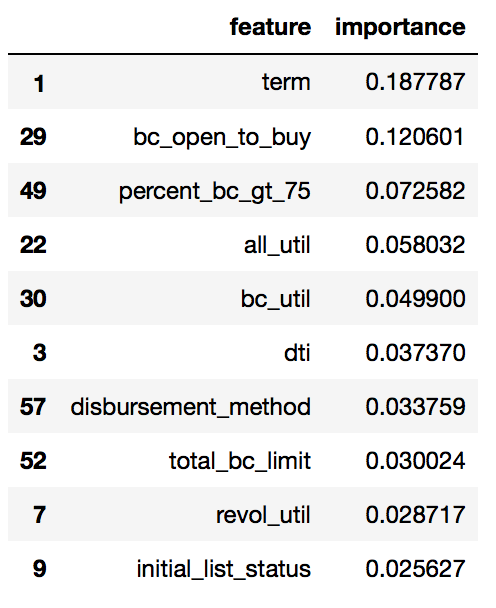

In [42]:
feature_importance_RF = Image.open("../image/Interest_Rate_Features_importance_RF.png")
feature_importance_RF

### 5.2 Model Comparison (Metric evaulations)
At here, I have two defined objectives, mean squared error and R-squared, to evaluate a continuous regression problem.
For the Lending Club, it can decide a model deployment by a predefined objective. It might care a lot on the MSE as long as the variance is not too high. Thus, **GB Regression** is preferred here.

| Model | MSE | R-squared (model explained variance / total original variance) |
| ---  | --- | --- |
| Linear Regression | 13.36 | **0.40** |
| Bagged Decision Tree Regression| 10.73 | 0.52 |
| Random Forest Regression| 10.18 | 0.54 |
| **GB Regression**| **9.34** | 0.58 |

### 5.3 Next Step

The predictive power of our models is week here(MSE is high), this might because that Lending Club decide the interest rate based more on set of qualitative norms or quantitative data that are not in our dataset. 

To build better models, we should spend more time to understand Lending Club's business model and interest rate decision making process to get more related and complete dataset.